## Getting Historical Data

So far there are 2 known method to get weather data:

1. Meteostat: easy, many nans
2. Dataset Archive NCAR RDA: complicated (need to use existing code to process), data size too big, doesnt have nans

In [1]:
import pandas as pd

### Meteostat

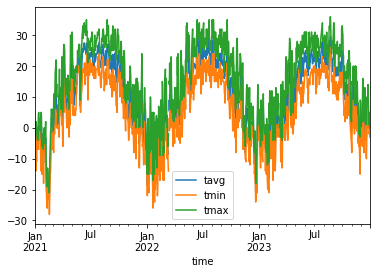

In [2]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily, Hourly

# Set time period
start = datetime(2021, 1, 1)
end = datetime(2023, 12, 31)

# Create Point for Vancouver, BC
iowa = Point(41.8780, -93.0977)

# Get daily data for 2018
data = Daily(iowa, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()

In [3]:
data = Hourly(iowa, start, end)

In [4]:
df = data.fetch()

In [5]:
df

temp  dwpt   rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                            
2021-01-01 00:00:00 -10.0 -10.0  100.0   NaN   NaN    NaN   NaN   NaN     NaN   
2021-01-01 01:00:00 -10.0 -10.0  100.0   0.0   NaN  100.0  13.0   NaN  1025.5   
2021-01-01 02:00:00  -8.0  -8.0  100.0   0.0   NaN  130.0  14.8   NaN  1025.7   
2021-01-01 03:00:00  -6.0  -6.0  100.0   0.0   NaN  140.0  14.8   NaN  1026.2   
2021-01-01 04:00:00  -6.0  -6.0  100.0   0.0   NaN  130.0  13.0   NaN  1026.0   
...                   ...   ...    ...   ...   ...    ...   ...   ...     ...   
2023-12-30 20:00:00   5.0   4.0   93.0   0.0   NaN  290.0  22.3   NaN  1011.0   
2023-12-30 21:00:00   4.0   2.0   87.0   0.0   NaN  300.0  22.3   NaN  1011.0   
2023-12-30 22:00:00   4.0   2.0   87.0   0.0   NaN  290.0  18.4   NaN  1011.0   
2023-12-30 23:00:00   4.0   2.0   87.0   0.0   NaN  320.0  20.5   NaN  1012.0   
2023-12-31 00:00:00   2.0   1.0   93.0   0.0   NaN  340.0  24.1   NaN  1013.0   

                     tsun  coco  
time                             
2021-01-01 00:00:00   NaN   5.0  
2021-01-01 01:00:00   NaN   5.0  
2021-01-01 02:00:00   NaN   5.0  
2021-01-01 03:00:00   NaN   NaN  
2021-01-01 04:00:00   NaN   5.0  
...                   ...   ...  
2023-12-30 20:00:00   NaN   3.0  
2023-12-30 21:00:00   NaN   3.0  
2023-12-30 22:00:00   NaN   3.0  
2023-12-30 23:00:00   NaN   1.0  
2023-12-31 00:00:00   NaN   1.0  

[26257 rows x 11 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26257 entries, 2021-01-01 00:00:00 to 2023-12-31 00:00:00
Freq: H
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    26257 non-null  float64
 1   dwpt    26257 non-null  float64
 2   rhum    26257 non-null  float64
 3   prcp    26256 non-null  float64
 4   snow    0 non-null      float64
 5   wdir    26256 non-null  float64
 6   wspd    26256 non-null  float64
 7   wpgt    0 non-null      float64
 8   pres    26256 non-null  float64
 9   tsun    0 non-null      float64
 10  coco    15601 non-null  float64
dtypes: float64(11)
memory usage: 2.4 MB


<p>Column	Description	Type</p>
<p>station	The Meteostat ID of the weather station (only if query refers to multiple stations)	String</p>
<p>time	The datetime of the observation	Datetime64</p>
<p>temp	The air temperature in °C	Float64</p>
<p>dwpt	The dew point in °C	Float64</p>
<p>rhum	The relative humidity in percent (%)	Float64</p>
<p>prcp	The one hour precipitation total in mm	Float64</p>
<p>snow	The snow depth in mm	Float64</p>
<p>wdir	The average wind direction in degrees (°)	Float64</p>
<p>wspd	The average wind speed in km/h	Float64</p>
<p>wpgt	The peak wind gust in km/h	Float64</p>
<p>pres	The average sea-level air pressure in hPa	Float64</p>
<p>tsun	The one hour sunshine total in minutes (m)	Float64</p>
<p>coco	The weather condition code	Float64</p>

In [7]:
df.to_csv('../GhostPostCC/data/weather_hist_iowa.csv')

### Dataset Archive NCAR RDA

In [7]:
'''
This file uses the code from https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7 
for the below two functions:
    earth_radius()
    area_grid()
These functions aggregate the weather data over a specified bounding box.
'''


import subprocess
from collections import namedtuple
from calendar import monthrange
import os.path
import pandas as pd
import csv
import math
import numpy as np

In [8]:
ISO_LIST = ["AUS_QLD"]
# IF 2 CONSECUTIVE FILES ARE NOT PRESENT, MANUALLY ADD THEM

GRIB2_CMD = "grib2/wgrib2/wgrib2"
# FILE_DIR = "gfs.0p25.2020010100-2021010100.f000.grib2/"

FILE_PREFIX = "gfs.0p25."
UGRD_VGRD_SEPRATOR = {"CISO": 1886, "PJM": 2556, "SE": 2296, "DK-DK2": 221, 
                        "ERCO": 2116, "ISNE": 1056, "GB": 1978, "DE": 1254, 
                        "PL": 984, "AUS_NSW": 64, "AUS_QLD": 5695, "AUS_SA": 2809}
TMP_DPT_SEPARATOR = {"CISO": 1886, "PJM": 2556, "SE": 2296, "DK-DK2": 221, 
                        "ERCO": 2116, "ISNE": 1056, "GB": 1978, "DE": 1254, 
                        "PL": 984, "AUS_NSW": 64, "AUS_QLD": 5695, "AUS_SA": 2809}

HOUR = ["00"] ##, "06", "12", "18"]
FCST = ["000", "003", "006", "009", "012", "015", "018", "021", "024",
                "027", "030", "033", "036", "039", "042", "045", "048",
                "051", "054", "057", "060", "063", "066", "069", "072",
                "075", "078", "081", "084", "087", "090", "093", "096"]
FCST_AVG_ACC = ["003", "006", "009", "012", "015", "018", "021", "024",
                "027", "030", "033", "036", "039", "042", "045", "048",
                "051", "054", "057", "060", "063", "066", "069", "072",
                "075", "078", "081", "084", "087", "090", "093", "096"]
YEARS = [2022, 2023, 2024]
HEADER = ["startDate", "endDate", "param", "level", "longitude", "latitude", "value"]
CSV_FILE_FIELDS_FCST = ["datetime", "param", "level", "latitude", "longitude", "Analysis", "3 hr fcst", 
        "6 hr fcst", "9 hr fcst", "12 hr fcst", "15 hr fcst", "18 hr fcst",
        "21 hr fcst", "24 hr fcst", "27 hr fcst", "30 hr fcst", "33 hr fcst",
        "36 hr fcst", "39 hr fcst", "42 hr fcst", "45 hr fcst", "48 hr fcst",
        "51 hr fcst", "54 hr fcst", "57 hr fcst", "60 hr fcst", "63 hr fcst",
        "66 hr fcst", "69 hr fcst", "72 hr fcst", "75 hr fcst", "78 hr fcst",
        "81 hr fcst", "84 hr fcst", "87 hr fcst", "90 hr fcst", "93 hr fcst", "96 hr fcst"]
CSV_FILE_FIELDS_AVG = ["datetime", "param", "level", "latitude", "longitude", "0-3 hr avg", 
        "0-6 hr avg", "6-9 hr avg", "6-12 hr avg", "12-15 hr avg", "12-18 hr avg",
        "18-21 hr avg", "18-24 hr avg", "24-27 hr avg", "24-30 hr avg", "30-33 hr avg",
        "30-36 hr avg", "36-39 hr avg", "36-42 hr avg", "42-45 hr avg", "42-48 hr avg",
        "48-51 hr avg", "48-54 hr avg", "54-57 hr avg", "54-60 hr avg", "60-63 hr avg",
        "60-66 hr avg", "66-69 hr avg", "66-72 hr avg", "72-75 hr avg", "72-78 hr avg",
        "78-81 hr avg", "78-84 hr avg", "84-87 hr avg", "84-90 hr avg", "90-93 hr avg", "90-96 hr avg"] 
CSV_FILE_FIELDS_ACC = ["datetime", "param", "level", "latitude", "longitude", "0-3 hr acc", 
        "0-6 hr acc", "6-9 hr acc", "6-12 hr acc", "12-15 hr acc", "12-18 hr acc",
        "18-21 hr acc", "18-24 hr acc", "24-27 hr acc", "24-30 hr acc", "30-33 hr acc",
        "30-36 hr acc", "36-39 hr acc", "36-42 hr acc", "42-45 hr acc", "42-48 hr acc",
        "48-51 hr acc", "48-54 hr acc", "54-57 hr acc", "54-60 hr acc", "60-63 hr acc",
        "60-66 hr acc", "66-69 hr acc", "66-72 hr acc", "72-75 hr acc", "72-78 hr acc",
        "78-81 hr acc", "78-84 hr acc", "84-87 hr acc", "84-90 hr acc", "90-93 hr acc", "90-96 hr acc"] 

In [9]:
def getFileList(yearList=[2022, 2023, 2024], fileDir = None, fcstCol=FCST):
    fileList = []
    prevFile = None
    for year in yearList:
        for month in range(1, 13): # Month is always 1..12
            for day in range(1, monthrange(year, month)[1] + 1):
                curDate = str(year)+f"{month:02d}"+f"{day:02d}"
                fileName = FILE_PREFIX + str(curDate)
                oldFileName = fileName
                for hr in HOUR:
                    for fcst in fcstCol:
                        fileName = oldFileName
                        fileName +=str(hr) + ".f"+str(fcst)+".grib2"
                        filePath = ""
                        filePath = fileDir + fileName
                        if (os.path.exists(filePath) == False):
                            print(filePath + " doesn't exist")
                            filePath = fileDir + str(prevFile)
                            if (os.path.exists(filePath) == True):
                                fileList.append(filePath)
                                print("Using previous forecast value with file: ", prevFile)
                            else:
                                print(filePath + " doesn't exist also")
                        else:
                            fileList.append(filePath)
                            prevFile = fileName # assuming the first file to be searched is always present
    return fileList

def getWeatherData(fileList, csvFields, outFileName, fcstCol, weatherVariable):
    with open(outFileName, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile)                    
        # writing the fields 
        csvwriter.writerow(csvFields)
    fileIdx = 0
    rows = []
    while fileIdx < len(fileList):
        row = None
        lat = None
        lon = None
        # weatherValues = []
        for i in range(len(fcstCol)):
            val = subprocess.call(GRIB2_CMD + " " + fileList[fileIdx] + " -csv tmp.csv", shell=True)
            fileIdx+=1
            if(val == 0):
                dataset = pd.read_csv("tmp.csv", infer_datetime_format=True, 
                        names=HEADER) #, header=0,  parse_dates=['UTC time'], index_col=['UTC time'])    
                # print(dataset.head(2))
                if (weatherVariable == "TEMP"):
                    dataset = dataset[:TMP_DPT_SEPARATOR[ISO]]
                elif (weatherVariable == "DPT"):
                    dataset = dataset[TMP_DPT_SEPARATOR[ISO]:]
                if (i==0):
                    lat = np.unique(dataset["latitude"].values)
                    lon = np.unique(dataset["longitude"].values)
                    grid_cell_area = area_grid(lat, lon)
                    total_area_of_earth = np.sum(grid_cell_area)
                # averageValue = round(dataset["value"].mean(), 5)
                
                if row is None:
                    row = [dataset["startDate"].iloc[0], dataset["param"].iloc[0], dataset["level"].iloc[0],
                                dataset["latitude"].iloc[0], dataset["longitude"].iloc[0]]

                value = dataset["value"].values
                # weighted_mean = np.mean(temperature)
                value = np.reshape(value, (len(lat), len(lon)))
                weighted_mean = (value * grid_cell_area) / total_area_of_earth
                weighted_mean = np.sum(weighted_mean)
                row.append(weighted_mean)
                delFile = subprocess.call("rm tmp.csv", shell=True)
                if(delFile != 0):
                    print("Error: Process call failed -- rm")
            else:
                print("Error: Process call failed -- ", GRIB2_CMD)
        # writing to csv file
        # print(weatherValues)
        # row.extend(weatherValues) 
        rows.append(row)
    with open(outFileName, 'a') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(rows)

    return

def getWindData(fileList, csvFields, outFileName):
    # print(len(fileList))
    # exit(0)
    with open(outFileName, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile)                    
        # writing the fields 
        csvwriter.writerow(csvFields)
    fileIdx = 0
    rows = []
    
    while fileIdx < len(fileList):
        row = None
        lat = None
        lon = None
        grid_cell_area = None
        total_area_of_earth = None
        # weatherValues = []
        for i in range(len(FCST)):
            val = subprocess.call(GRIB2_CMD + " " + fileList[fileIdx] + " -csv tmp.csv", shell=True)
            fileIdx+=1
            if(val == 0):
                dataset = pd.read_csv("tmp.csv", infer_datetime_format=True, 
                        names=HEADER) #, header=0,  parse_dates=['UTC time'], index_col=['UTC time'])    
                # print(dataset.head(2))
                vdataset = dataset[UGRD_VGRD_SEPRATOR[ISO]:]
                udataset = dataset[:UGRD_VGRD_SEPRATOR[ISO]]
                if (i==0):
                    lat = np.unique(dataset["latitude"].values)
                    lon = np.unique(dataset["longitude"].values)
                    grid_cell_area = area_grid(lat, lon)
                    total_area_of_earth = np.sum(grid_cell_area)
                if row is None:
                    row = [dataset["startDate"].iloc[0], dataset["param"].iloc[0], dataset["level"].iloc[0],
                                dataset["latitude"].iloc[0], dataset["longitude"].iloc[0]]

                windSpeed = (udataset["value"].values**2 + vdataset["value"].values**2)**(0.5)
                # weighted_mean = np.mean(temperature)
                value = np.reshape(windSpeed, (len(lat), len(lon)))
                weighted_mean = (value * grid_cell_area) / total_area_of_earth
                weighted_mean = np.sum(weighted_mean)
                row.append(weighted_mean)
                
                delFile = subprocess.call("rm tmp.csv", shell=True)
                if(delFile != 0):
                    print("Error: Process call failed -- rm")
            else:
                print("Error: Process call failed -- ", GRIB2_CMD)
        # writing to csv file
        # print(weatherValues)
        # row.extend(weatherValues) 
        rows.append(row)
    with open(outFileName, 'a') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(rows)

    return

def addColumnToCSVFile(fileName, newColName, newColValue):
    dataset = pd.read_csv(fileName, header=0)
    dataset[newColName] = newColValue
    dataset.to_csv(fileName)
    return

def getWindSpeedAcrossAllRegions(inFileName):
    maxWindSpeedList = []
    totalWindSpeedList = []
    avgWindSpeedList = []
    uWindFileList = None
    if (inFileName is None):
        uWindFileList = getFileList(2020, "SE/ugrd_vgrd/")
    else:
        uWindFileList = getFileList(2020, inFileName)
    # vWindFileList = getFileList(2020, "ds084_1/vGRD/")
    fileIdx = 0
    rows = []
    while fileIdx < len(uWindFileList):
        row = None
        # weatherValues = []
        for i in range(len(FCST)):
            uval = subprocess.call(GRIB2_CMD + " " + uWindFileList[fileIdx] + " -csv utmp.csv", shell=True)
            if(uval == 0):
                vval = 0 #subprocess.call(GRIB2_CMD + " " + vWindFileList[fileIdx] + " -csv vtmp.csv", shell=True)
                fileIdx+=1
                if (vval == 0):
                    udataset = pd.read_csv("utmp.csv", infer_datetime_format=True, 
                            names=HEADER)
                    # vdataset = pd.read_csv("vtmp.csv", infer_datetime_format=True, 
                    #         names=HEADER)
                    vdataset = udataset[UGRD_VGRD_SEPRATOR[ISO]:]
                    udataset = udataset[:UGRD_VGRD_SEPRATOR[ISO]]
                    # if row is None:
                    #     row = [dataset["startDate"].iloc[cityIdx], dataset["param"].iloc[cityIdx], dataset["level"].iloc[cityIdx],
                    #                 dataset["latitude"].iloc[cityIdx], dataset["longitude"].iloc[cityIdx]]

                    maxWindSpeed = 0
                    totalWindSpeed = 0
                    avgWindSpeed = 0
                    for j in range(len(udataset)):
                        u = udataset["value"].iloc[j]
                        v = vdataset["value"].iloc[j]
                        windSpeed = math.sqrt(u*u + v*v)
                        totalWindSpeed +=windSpeed
                        if  windSpeed> maxWindSpeed:
                            maxWindSpeed = windSpeed
                    avgWindSpeed = totalWindSpeed/len(udataset)
                    maxWindSpeedList.append([udataset["startDate"].iloc[0], maxWindSpeed])
                    totalWindSpeedList.append([udataset["startDate"].iloc[0], totalWindSpeed])
                    avgWindSpeedList.append([udataset["startDate"].iloc[0], avgWindSpeed])
                    # delFile = subprocess.call("rm utmp.csv", shell=True)
                    # if(delFile != 0):
                    #     print("Error: Process call failed -- rm")
                else:
                    print("Error: Process call failed -- ", GRIB2_CMD)
            else:
                print("Error: Process call failed -- ", GRIB2_CMD)
        # writing to csv file
        # print(weatherValues)
        # row.extend(weatherValues) 
        # rows.append(row)
    return maxWindSpeedList, totalWindSpeedList, avgWindSpeedList

def getTotalDWSRFcrossAllRegions():
    totalWindSpeedList = []
    avgWindSpeedList = []
    dswrfFileList = getFileList(2020, "PJM/dswrf/")
    # vWindFileList = getFileList(2020, "ds084_1/vGRD/")
    fileIdx = 0
    rows = []
    while fileIdx < len(dswrfFileList):
        row = None
        # weatherValues = []
        for i in range(len(FCST)):
            uval = subprocess.call(GRIB2_CMD + " " + dswrfFileList[fileIdx] + " -csv utmp.csv", shell=True)
            if(uval == 0):
                fileIdx+=1
                udataset = pd.read_csv("utmp.csv", infer_datetime_format=True, 
                        names=HEADER)
                totalWindSpeed = np.sum(udataset["value"].values)
                avgWindSpeed = np.average(udataset["value"].values)
                totalWindSpeedList.append([udataset["startDate"].iloc[0], totalWindSpeed])
                avgWindSpeedList.append([udataset["startDate"].iloc[0], avgWindSpeed])
            else:
                print("Error: Process call failed -- ", GRIB2_CMD)
        # writing to csv file
        # print(weatherValues)
        # row.extend(weatherValues) 
        # rows.append(row)
    return totalWindSpeedList, avgWindSpeedList

def earth_radius(lat):
    '''
    calculate radius of Earth assuming oblate spheroid
    defined by WGS84
    
    Input
    ---------
    lat: vector or latitudes in degrees  
    
    Output
    ----------
    r: vector of radius in meters
    
    Notes
    -----------
    WGS84: https://earth-info.nga.mil/GandG/publications/tr8350.2/tr8350.2-a/Chapter%203.pdf
    '''
    from numpy import deg2rad, sin, cos

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )

    # print("Earth radius:", r ,len(r))
    return r

def area_grid(lat, lon):
    """
    Calculate the area of each grid cell
    Area is in square meters
    
    Input
    -----------
    lat: vector of latitude in degrees
    lon: vector of longitude in degrees
    
    Output
    -----------
    area: grid-cell area in square-meters with dimensions, [lat,lon]
    
    Notes
    -----------
    Based on the function in
    https://github.com/chadagreene/CDT/blob/master/cdt/cdtarea.m
    """
    from numpy import meshgrid, deg2rad, gradient, cos
    from xarray import DataArray

    xlon, ylat = meshgrid(lon, lat)
    # print(ylat)
    R = earth_radius(ylat)

    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))

    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))

    area = dy * dx
    # print("Area shape: ", area.shape, type(area))
    return area

# # maxWindSpeedList, totalWindSpeedList, avgWindSpeedList = getWindSpeedAcrossAllRegions()
# totalDwsrfList, avgDwsrfList = getTotalDWSRFcrossAllRegions()
# # pd.DataFrame(maxWindSpeedList).to_csv("SE_maxWS.csv")
# pd.DataFrame(totalDwsrfList).to_csv("PJM_totalDWSRF.csv")
# pd.DataFrame(avgDwsrfList).to_csv("PJM_avgDWSRF.csv")

In [10]:
for ISO in ISO_LIST:
    # FILE_DIR = ["../final_weather_data/"+ISO+"/ugrd_vgrd/", #/2019_weather_data
    #         "../final_weather_data/"+ISO+"/tmp_dpt/",
    #         "../final_weather_data/"+ISO+"/tmp_dpt/",
    #         "../final_weather_data/"+ISO+"/dswrf/",
    #         "../final_weather_data/"+ISO+"/apcp/"]

    # OUT_FILE_NAME_LIST = ["../final_weather_data/"+ISO+"/"+ISO+"_AVG_WIND_SPEED.csv", #/2019_weather_data
    #                     "../final_weather_data/"+ISO+"/"+ISO+"_AVG_TEMP.csv",
    #                     "../final_weather_data/"+ISO+"/"+ISO+"_AVG_DPT.csv",
    #                     "../final_weather_data/"+ISO+"/"+ISO+"_AVG_DSWRF.csv",
    #                     "../final_weather_data/"+ISO+"/"+ISO+"_AVG_PCP.csv"]

    FILE_DIR = ["../data/"+ISO+"/weather_data/ugrd_vgrd/",
            "../data/"+ISO+"/weather_data/tmp_dpt/",
            "../data/"+ISO+"/weather_data/tmp_dpt/",
            "../data/"+ISO+"/weather_data/dswrf/",
            "../data/"+ISO+"/weather_data/apcp/"]

    OUT_FILE_NAME_LIST = ["../data/"+ISO+"/weather_data/"+ISO+"_AVG_WIND_SPEED.csv",
                        "../data/"+ISO+"/weather_data/"+ISO+"_AVG_TEMP.csv",
                        "../data/"+ISO+"/weather_data/"+ISO+"_AVG_DPT.csv",
                        "../data/"+ISO+"/weather_data/"+ISO+"_AVG_DSWRF.csv",
                        "../data/"+ISO+"/weather_data/"+ISO+"_AVG_PCP.csv"]

    # FILE_DIR = ["../data/"+ISO+"/weather_data/tmp_dpt/",
    #         "../data/"+ISO+"/weather_data/tmp_dpt/"]
            
    # OUT_FILE_NAME_LIST = ["../data/"+ISO+"/weather_data/"+ISO+"_AVG_TEMP.csv",
    #                     "../data/"+ISO+"/weather_data/"+ISO+"_AVG_DPT.csv"]

    print("*******************", ISO, "*******************")
    for xx in range(len(OUT_FILE_NAME_LIST)):
        if ("WIND" in OUT_FILE_NAME_LIST[xx]):
            fileList = getFileList(YEARS, FILE_DIR[xx], fcstCol=FCST)
            print("WIND: ", OUT_FILE_NAME_LIST[xx])
            getWindData(fileList, CSV_FILE_FIELDS_FCST, OUT_FILE_NAME_LIST[xx])
        else:
            if ("TEMP" in OUT_FILE_NAME_LIST[xx]):
                fileList = getFileList(YEARS, FILE_DIR[xx], fcstCol=FCST)
                print("TEMP: ", OUT_FILE_NAME_LIST[xx])
                getWeatherData(fileList, CSV_FILE_FIELDS_FCST, OUT_FILE_NAME_LIST[xx], FCST, "TEMP")
            elif ("DPT" in OUT_FILE_NAME_LIST[xx]):
                fileList = getFileList(YEARS, FILE_DIR[xx], fcstCol=FCST)
                print("DPT: ", OUT_FILE_NAME_LIST[xx])
                getWeatherData(fileList, CSV_FILE_FIELDS_FCST, OUT_FILE_NAME_LIST[xx], FCST, "DPT")
            elif ("DSWRF" in OUT_FILE_NAME_LIST[xx]):
                fileList = getFileList(YEARS, FILE_DIR[xx], fcstCol=FCST_AVG_ACC)
                print("DSWRF: ", OUT_FILE_NAME_LIST[xx])
                getWeatherData(fileList, CSV_FILE_FIELDS_AVG, OUT_FILE_NAME_LIST[xx], FCST_AVG_ACC, "DSWRF")
            elif ("PCP" in OUT_FILE_NAME_LIST[xx]):
                fileList = getFileList(YEARS, FILE_DIR[xx], fcstCol=FCST_AVG_ACC)
                print("PCP: ", OUT_FILE_NAME_LIST[xx])
                getWeatherData(fileList, CSV_FILE_FIELDS_ACC, OUT_FILE_NAME_LIST[xx], FCST_AVG_ACC, "PCP")
    print("*******************", ISO, " done *******************")

******************* AUS_QLD *******************
../data/AUS_QLD/weather_data/ugrd_vgrd/gfs.0p25.2022010100.f000.grib2 doesn't exist
../data/AUS_QLD/weather_data/ugrd_vgrd/None doesn't exist also
../data/AUS_QLD/weather_data/ugrd_vgrd/gfs.0p25.2022010100.f003.grib2 doesn't exist
../data/AUS_QLD/weather_data/ugrd_vgrd/None doesn't exist also
../data/AUS_QLD/weather_data/ugrd_vgrd/gfs.0p25.2022010100.f006.grib2 doesn't exist
../data/AUS_QLD/weather_data/ugrd_vgrd/None doesn't exist also
../data/AUS_QLD/weather_data/ugrd_vgrd/gfs.0p25.2022010100.f009.grib2 doesn't exist
../data/AUS_QLD/weather_data/ugrd_vgrd/None doesn't exist also
../data/AUS_QLD/weather_data/ugrd_vgrd/gfs.0p25.2022010100.f012.grib2 doesn't exist
../data/AUS_QLD/weather_data/ugrd_vgrd/None doesn't exist also
../data/AUS_QLD/weather_data/ugrd_vgrd/gfs.0p25.2022010100.f015.grib2 doesn't exist
../data/AUS_QLD/weather_data/ugrd_vgrd/None doesn't exist also
../data/AUS_QLD/weather_data/ugrd_vgrd/gfs.0p25.2022010100.f018.grib2 

FileNotFoundError: [Errno 2] No such file or directory: '../data/AUS_QLD/weather_data/AUS_QLD_AVG_WIND_SPEED.csv'

## Getting Forecast from NWS

In [ ]:
import requests

In [ ]:
iowa = [41.8780, -93.0977]

In [ ]:
response = requests.get(f"https://api.weather.gov/points/{iowa[0]},{iowa[1]}").json()

In [ ]:
response

{'@context': ['https://geojson.org/geojson-ld/geojson-context.jsonld',
  {'@version': '1.1',
   'wx': 'https://api.weather.gov/ontology#',
   's': 'https://schema.org/',
   'geo': 'http://www.opengis.net/ont/geosparql#',
   'unit': 'http://codes.wmo.int/common/unit/',
   '@vocab': 'https://api.weather.gov/ontology#',
   'geometry': {'@id': 's:GeoCoordinates', '@type': 'geo:wktLiteral'},
   'city': 's:addressLocality',
   'state': 's:addressRegion',
   'distance': {'@id': 's:Distance', '@type': 's:QuantitativeValue'},
   'bearing': {'@type': 's:QuantitativeValue'},
   'value': {'@id': 's:value'},
   'unitCode': {'@id': 's:unitCode', '@type': '@id'},
   'forecastOffice': {'@type': '@id'},
   'forecastGridData': {'@type': '@id'},
   'publicZone': {'@type': '@id'},
   'county': {'@type': '@id'}}],
 'id': 'https://api.weather.gov/points/41.878,-93.0977',
 'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [-93.0977, 41.878]},
 'properties': {'@id': 'https://api.weather.gov/poi

In [ ]:
data = requests.get(response['properties']['forecastHourly']).json()

In [ ]:
data

{'@context': ['https://geojson.org/geojson-ld/geojson-context.jsonld',
  {'@version': '1.1',
   'wx': 'https://api.weather.gov/ontology#',
   'geo': 'http://www.opengis.net/ont/geosparql#',
   'unit': 'http://codes.wmo.int/common/unit/',
   '@vocab': 'https://api.weather.gov/ontology#'}],
 'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-93.11101, 41.8967311],
    [-93.11141819999999, 41.8749184],
    [-93.08213439999999, 41.874612299999995],
    [-93.08171979999999, 41.896424999999994],
    [-93.11101, 41.8967311]]]},
 'properties': {'updated': '2024-04-27T14:50:48+00:00',
  'units': 'us',
  'forecastGenerator': 'HourlyForecastGenerator',
  'generatedAt': '2024-04-27T17:07:47+00:00',
  'updateTime': '2024-04-27T14:50:48+00:00',
  'validTimes': '2024-04-27T08:00:00+00:00/P7DT17H',
  'elevation': {'unitCode': 'wmoUnit:m', 'value': 305.1048},
  'periods': [{'number': 1,
    'name': '',
    'startTime': '2024-04-27T12:00:00-05:00',
    'endTime': '2024-04-27T13:00:

In [ ]:
data['properties']['periods']

[{'number': 1,
  'name': '',
  'startTime': '2024-04-27T12:00:00-05:00',
  'endTime': '2024-04-27T13:00:00-05:00',
  'isDaytime': True,
  'temperature': 69,
  'temperatureUnit': 'F',
  'temperatureTrend': None,
  'probabilityOfPrecipitation': {'unitCode': 'wmoUnit:percent', 'value': 7},
  'dewpoint': {'unitCode': 'wmoUnit:degC', 'value': 14.444444444444445},
  'relativeHumidity': {'unitCode': 'wmoUnit:percent', 'value': 68},
  'windSpeed': '13 mph',
  'windDirection': 'SW',
  'icon': 'https://api.weather.gov/icons/land/day/bkn,7?size=small',
  'shortForecast': 'Partly Sunny',
  'detailedForecast': ''},
 {'number': 2,
  'name': '',
  'startTime': '2024-04-27T13:00:00-05:00',
  'endTime': '2024-04-27T14:00:00-05:00',
  'isDaytime': True,
  'temperature': 71,
  'temperatureUnit': 'F',
  'temperatureTrend': None,
  'probabilityOfPrecipitation': {'unitCode': 'wmoUnit:percent', 'value': 9},
  'dewpoint': {'unitCode': 'wmoUnit:degC', 'value': 14.444444444444445},
  'relativeHumidity': {'unitC

In [ ]:
import pandas as pd

pd.DataFrame(data['properties']['periods'])

number name                  startTime                    endTime  \
0         1       2024-04-27T12:00:00-05:00  2024-04-27T13:00:00-05:00   
1         2       2024-04-27T13:00:00-05:00  2024-04-27T14:00:00-05:00   
2         3       2024-04-27T14:00:00-05:00  2024-04-27T15:00:00-05:00   
3         4       2024-04-27T15:00:00-05:00  2024-04-27T16:00:00-05:00   
4         5       2024-04-27T16:00:00-05:00  2024-04-27T17:00:00-05:00   
..      ...  ...                        ...                        ...   
151     152       2024-05-03T19:00:00-05:00  2024-05-03T20:00:00-05:00   
152     153       2024-05-03T20:00:00-05:00  2024-05-03T21:00:00-05:00   
153     154       2024-05-03T21:00:00-05:00  2024-05-03T22:00:00-05:00   
154     155       2024-05-03T22:00:00-05:00  2024-05-03T23:00:00-05:00   
155     156       2024-05-03T23:00:00-05:00  2024-05-04T00:00:00-05:00   

     isDaytime  temperature temperatureUnit temperatureTrend  \
0         True           69               F             None   
1         True           71               F             None   
2         True           73               F             None   
3         True           73               F             None   
4         True           74               F             None   
..         ...          ...             ...              ...   
151      False           59               F             None   
152      False           57               F             None   
153      False           54               F             None   
154      False           52               F             None   
155      False           51               F             None   

                       probabilityOfPrecipitation  \
0     {'unitCode': 'wmoUnit:percent', 'value': 7}   
1     {'unitCode': 'wmoUnit:percent', 'value': 9}   
2    {'unitCode': 'wmoUnit:percent', 'value': 14}   
3    {'unitCode': 'wmoUnit:percent', 'value': 25}   
4    {'unitCode': 'wmoUnit:percent', 'value': 31}   
..                                            ...   
151  {'unitCode': 'wmoUnit:percent', 'value': 20}   
152  {'unitCode': 'wmoUnit:percent', 'value': 20}   
153  {'unitCode': 'wmoUnit:percent', 'value': 20}   
154  {'unitCode': 'wmoUnit:percent', 'value': 20}   
155  {'unitCode': 'wmoUnit:percent', 'value': 20}   

                                              dewpoint  \
0    {'unitCode': 'wmoUnit:degC', 'value': 14.44444...   
1    {'unitCode': 'wmoUnit:degC', 'value': 14.44444...   
2    {'unitCode': 'wmoUnit:degC', 'value': 14.44444...   
3            {'unitCode': 'wmoUnit:degC', 'value': 15}   
4            {'unitCode': 'wmoUnit:degC', 'value': 15}   
..                                                 ...   
151  {'unitCode': 'wmoUnit:degC', 'value': 6.111111...   
152  {'unitCode': 'wmoUnit:degC', 'value': 6.111111...   
153  {'unitCode': 'wmoUnit:degC', 'value': 5.555555...   
154  {'unitCode': 'wmoUnit:degC', 'value': 5.555555...   
155  {'unitCode': 'wmoUnit:degC', 'value': 5.555555...   

                                 relativeHumidity windSpeed windDirection  \
0    {'unitCode': 'wmoUnit:percent', 'value': 68}    13 mph            SW   
1    {'unitCode': 'wmoUnit:percent', 'value': 63}    13 mph            SW   
2    {'unitCode': 'wmoUnit:percent', 'value': 59}    13 mph            SW   
3    {'unitCode': 'wmoUnit:percent', 'value': 62}    12 mph            SW   
4    {'unitCode': 'wmoUnit:percent', 'value': 59}    10 mph           SSW   
..                                            ...       ...           ...   
151  {'unitCode': 'wmoUnit:percent', 'value': 55}    16 mph           WNW   
152  {'unitCode': 'wmoUnit:percent', 'value': 59}    16 mph             W   
153  {'unitCode': 'wmoUnit:percent', 'value': 64}    15 mph             W   
154  {'unitCode': 'wmoUnit:percent', 'value': 69}    15 mph             W   
155  {'unitCode': 'wmoUnit:percent', 'value': 71}    15 mph           WSW   

                                                  icon  \
0    https://api.weather.gov/i

In [13]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [14]:
from requests.auth import HTTPBasicAuth
import requests

url = f"https://api.eia.gov/v2/electricity/rto/region-data/data/?frequency=hourly&data[0]=value&start=2022-01-01T00&end=2024-04-30T00&sort[0][column]=period&sort[0][direction]=desc&offset=5815340&api_key={os.getenv('EIA_API_KEY')}"
headers = {"frequency": "hourly",
    "data": [
        "value"
    ],
    "facets": {},
    "start": "2022-01-01T00",
    "end": "2024-04-30T00",
    "sort": [
        {
            "column": "period",
            "direction": "desc"
        }
    ],
    "offset": 5815340,
    "length": 5000}
auth = HTTPBasicAuth('apikey', 'JtlyggzhwQyEktgzvkWJ4rhwYzA3nUJHfBfiHu0w')

response = requests.get(url).json()

In [15]:
response

{'response': {'warnings': [{'warning': 'incomplete return',
    'description': 'The API can only return 5000 rows in JSON format.  Please consider constraining your request with facet, start, or end, or using offset to paginate results.'}],
  'total': '5824929',
  'dateFormat': 'YYYY-MM-DD"T"HH24',
  'frequency': 'hourly',
  'data': [{'period': '2022-01-02T09',
    'respondent': 'US48',
    'respondent-name': 'United States Lower 48',
    'type': 'TI',
    'type-name': 'Total interchange',
    'value': '-3761',
    'value-units': 'megawatthours'},
   {'period': '2022-01-02T09',
    'respondent': 'WALC',
    'respondent-name': 'Western Area Power Administration - Desert Southwest Region',
    'type': 'NG',
    'type-name': 'Net generation',
    'value': '976',
    'value-units': 'megawatthours'},
   {'period': '2022-01-02T09',
    'respondent': 'FLA',
    'respondent-name': 'Florida',
    'type': 'NG',
    'type-name': 'Net generation',
    'value': '17653',
    'value-units': 'megawatt

In [19]:
response.keys()

dict_keys(['response', 'request', 'apiVersion', 'ExcelAddInVersion'])

In [23]:
import pandas as pd

In [24]:
pd.DataFrame(response['response']['data'])

period respondent  \
0     2022-01-02T09       US48   
1     2022-01-02T09       WALC   
2     2022-01-02T09        FLA   
3     2022-01-02T09        FPC   
4     2022-01-02T09        PGE   
...             ...        ...   
4995  2022-01-01T15       NEVP   
4996  2022-01-01T15        FPL   
4997  2022-01-01T15       SWPP   
4998  2022-01-01T15        GWA   
4999  2022-01-01T15       AVRN   

                                        respondent-name type  \
0                                United States Lower 48   TI   
1     Western Area Power Administration - Desert Sou...   NG   
2                                               Florida   NG   
3                             Duke Energy Florida, Inc.   DF   
4                     Portland General Electric Company   DF   
...                                                 ...  ...   
4995                               Nevada Power Company   TI   
4996                          Florida Power & Light Co.   TI   
4997                               Southwest Power Pool   NG   
4998                         NaturEner Power Watch, LLC   NG   
4999                           Avangrid Renewables, LLC   TI   

                      type-name  value    value-units  
0             Total interchange  -3761  megawatthours  
1                Net generation    976  megawatthours  
2                Net generation  17653  megawatthours  
3     Day-ahead demand forecast   2990  megawatthours  
4     Day-ahead demand forecast   2676  megawatthours  
...                         ...    ...            ...  
4995          Total interchange   -290  megawatthours  
4996          Total interchange    621  megawatthours  
4997             Net generation  31297  megawatthours  
4998             Net generation      4  megawatthours  
4999          Total interchange    238  megawatthours  

[5000 rows x 7 columns]